In [1]:
!pip install yfinance --upgrade --no-cache-dir

In [2]:
pip install yahooquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 41.1 MB/s eta 0:00:00
  Attempting uninstall: lxml
    Found existing installation: lxml 5.3.1
    Uninstalling lxml-5.3.1:
      Successfully uninstalled lxml-5.3.1


# Git commands

In [ ]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [ ]:
!git remote add origin https://github.com/KaiSun19/OptionStrategyNotebook.git

In [ ]:
!git config --global user.email "yksun15@gmail.com"
!git config --global user.name "KaiSun19"

In [ ]:
!git branch -M main

In [ ]:
!git add .

In [ ]:
!git status

On branch master

No commits yet

Changes to be committed:
  (use "git rm --cached <file>..." to unstage)
	new file:   .config/.last_opt_in_prompt.yaml
	new file:   .config/.last_survey_prompt.yaml
	new file:   .config/.last_update_check.json
	new file:   .config/active_config
	new file:   .config/config_sentinel
	new file:   .config/configurations/config_default
	new file:   .config/default_configs.db
	new file:   .config/gce
	new file:   .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
	new file:   .config/logs/2025.04.03/13.36.12.967744.log
	new file:   .config/logs/2025.04.03/13.36.38.976090.log
	new file:   .config/logs/2025.04.03/13.36.48.370498.log
	new file:   .config/logs/2025.04.03/13.36.52.007481.log
	new file:   .config/logs/2025.04.03/13.37.01.149089.log
	new file:   .config/logs/2025.04.03/13.37.01.876958.log
	new file:   sample_data/README.md
	new file:   sample_data/anscombe.json
	new file:   sample_data/california_housing_test.csv
	new file:   sam

In [ ]:
!git commit -m "initial commit from google colab"

On branch master

Initial commit

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.config/
	sample_data/

nothing added to commit but untracked files present (use "git add" to track)


In [3]:
import datetime, time
from datetime import timedelta, datetime
import requests
import pandas as pd
import os.path
from os import path
import yfinance as yf
from yahooquery import Ticker
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.stats import norm
from pandas_datareader import data as pdr
import re
import json
import uuid
import firebase_admin
from firebase_admin import firestore, credentials
import time

In [4]:
etfs_list = ['SPY', 'QQQ', 'IWM', 'XLI', 'TQQQ','SOXL', 'HYG', 'TLT']
stocks_list = ['NVDA', 'TSLA', 'MSTR', 'AVGO','AAPL','PLTR', 'META', 'AMD']
symbols_list = stocks_list + etfs_list
required_columns = ['contractSymbol', 'strike', 'lastPrice', 'change', 'volume', 'impliedVolatility']
raw_option_data_indexes = ['symbol', 'expiration', 'optionType']

In [5]:
#general methods
def weighted_avg(data,opening_trades):
  return (data[0] * (opening_trades[0]/sum(opening_trades))) + (data[1] * (opening_trades[1]/sum(opening_trades))) + (data[2] * (opening_trades[2]/sum(opening_trades)))
def loading_stat(data, data_list):
  print(str(data) + ' ' +  str(round((data_list.index(data)/len(data_list) * 100),2)) + ' ' + '% done' )
def get_vol(symbol, period = '41d'):
  raw_price = pdr.get_data_yahoo(symbol, period = period).Close
  # log_returns = np.log1p(raw_price.pct_change())
  vol = np.std(raw_price)
  return vol
def get_future_date(days_from_today):
  today = datetime.today()
  future_date = today + timedelta(days=days_from_today)
  return future_date.strftime("%Y-%m-%d")
def get_current_price(symbol, period='1d'):
  try:
    return yf.download(symbol, period=period)['Close'].iloc[0][symbol.upper()]
  except Exception as e:
    print(f"Error retrieving price for {symbol}: {e}")
    return None
def start_point(symbol, option_type = 'c'):
  abs_start_diff = get_vol(symbol) / 3
  if option_type == 'c':
    return  round(pdr.get_data_yahoo(symbol, period = '5d').Close.iloc[-1] + abs_start_diff,2)
  elif option_type == 'p':
    return round(pdr.get_data_yahoo(symbol, period = '5d').Close.iloc[-1] - abs_start_diff,2)
def get_ivrank(symbol):
  loading_stat(symbol, assets_list)
  url = "https://marketchameleon.com/Overview/EWZ/IV/"
  r = requests.get(url)
  soup=bs4.BeautifulSoup(r.text, "lxml")
  print(soup)
  vol = soup.find_all("div", {"class" : "ov-head-stat"}).find_all()
  print(vol)
def valid_url(symbol):
  exchange_list = [ "ARCA","NASDAQ","NYSE"]
  tests =[]
  for x in exchange_list:
    url = "https://omnieq.com/underlyings/" + x + "/" + symbol
    r = requests.get(url)
    soup=bs4.BeautifulSoup(r.text, "lxml")
    test = soup.find_all("title")[0].text
    tests.append(test)
  loop1 = True
  ind = 0
  while loop1 == True:
    test = tests[ind]
    if test != "Page Not Found":
      loop1 = False
    else:
      ind += 1
  exchange = exchange_list[ind]
  return exchange
def generate_uuid():
  return str(uuid.uuid4())

In [6]:
#methods for analysing options data
def get_raw_options_data(symbol):
  return Ticker(symbol).option_chain

def get_expiration_dates(raw_options_df, date_range, inRange= False):
  dates = [x.strftime('%Y-%m-%d') for x in raw_options_df.index.get_level_values('expiration').unique()]
  if inRange:
    start_date = datetime.strptime(date_range[0], '%Y-%m-%d').date()
    end_date = datetime.strptime(date_range[1], '%Y-%m-%d').date()

    dates = [date for date in dates if start_date <= datetime.strptime(date, '%Y-%m-%d').date() <= end_date]
  return dates

def get_type_from_ticket(ticker):
  ticker_length = len(ticker)
  while ticker_length > 1 :
    if ticker[ticker_length - 1] == 'P':
      return 'put'
    elif ticker[ticker_length - 1] == 'C':
      return 'call'
    else:
      ticker_length -= 1
  return 'na'

def get_days_till_expiry(expiration_date):
  days = (datetime.strptime(expiration_date, '%Y-%m-%d')  - datetime.today()).days
  if days > 0:
    return days
  else:
    return 0.001
def risk_free_rate():
  """
  Returns the interest rate of a US Treasury 1-year bond using yfinance.
  """
  try:
    ticker = yf.Ticker('^FVX')
    data = ticker.history(period="1d")
    if not data.empty:
      interest_rate = data['Close'].iloc[0]/100
      return interest_rate
    else:
      print("Could not retrieve Treasury bond data.")
      return None
  except Exception as e:
    print(f"An error occurred: {e}")
    return None
def tune_risk_free_rate(start, real_delta):
  risk_free_rate = start
  delta = get_delta(stock_price, strike_price, tte, risk_free_rate, iv, 'put')
  while abs(delta - real_delta) > 0.0:
    delta = get_delta(stock_price, strike_price, tte, risk_free_rate, iv, 'put')
    if delta > real_delta:
      risk_free_rate -= 0.01
    else:
      risk_free_rate += 0.01
    print(risk_free_rate)
  return risk_free_rate
def get_delta(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return np.round(norm.cdf(d1) if option_type == 'call' else norm.cdf(d1) - 1, 3)

def calculate_correlation_matrix(stock_list):
  stock_data = {}
  for symbol in stock_list:
    stock_data[symbol] = np.array(yf.download(symbol, period='1y')['Close'][symbol])
  df = pd.DataFrame(stock_data)
  df = df.dropna()
  correlation_matrix = df.corr()
  fig, ax = plt.subplots(figsize=(12, 12))
  return sns.heatmap(correlation_matrix, annot=True, ax=ax)

def create_high_correlation_df(correlation_matrix, threshold=0.9):

  mask = correlation_matrix > threshold

  high_correlation_df = correlation_matrix[mask].stack().reset_index()
  high_correlation_df = high_correlation_df[high_correlation_df['level_0'] != high_correlation_df['level_1']]

  high_correlation_df.columns = ['Asset1', 'Asset2', 'Correlation']

  return high_correlation_df

In [ ]:
#code to access firebase

if not firebase_admin._apps:
  cred = credentials.Certificate("/content/optionsdata-5dc59-firebase-adminsdk-fbsvc-7c5da01f8d.json")

  # Application Default credentials are automatically created.
  app = firebase_admin.initialize_app(cred)
else:
  app = firebase_admin.get_app()
db = firestore.client(app)

In [7]:
#method to upload option data

def get_option_chains_to_upload(symbol):
  raw_options_chains = get_raw_options_data(symbol)
  option_expiration_dates = get_expiration_dates(raw_options_chains)
  current_date = time.strftime("%Y-%m-%d")
  option_data_final = []
  for date in option_expiration_dates:
    option_chain_filtered_df = raw_options_chains.loc[symbol, date][required_columns]
    option_chain_filtered_df['contractType'] = option_chain_filtered_df['contractSymbol'].apply(lambda x : get_type_from_ticket(x))
    option_data_final.append({ date : option_chain_filtered_df.reset_index(drop=True)})
  return option_data_final

def upload_daily_data(symbol):
  if db.collection(symbol).document(datetime.today().strftime('%d-%m-%Y')).get().exists:
    print('data already uploaded')
    return
  option_chains = get_option_chains_to_upload(symbol)
  batch = db.batch()
  batch_size = 100
  count = 0
  rate_limit_secs = 1

  for obj in option_chains:
    exp_date_key = list(obj.keys())[0]
    ticket_level_dict = {}
    for row in obj[exp_date_key].iterrows():
      ticket_level_dict[row[1]['contractSymbol']] = json.loads(row[1][['strike', 'lastPrice', 'volume', 'impliedVolatility', 'contractType']].to_json())
    doc_ref = db.collection(symbol).document(datetime.today().strftime('%d-%m-%Y')).collection(exp_date_key).document(generate_uuid())
    batch.set(doc_ref, ticket_level_dict)
    count += 1
    if count >= batch_size:
        batch.commit()
        batch = db.batch()
        count = 0
  time.sleep(rate_limit_secs)
  # Commit any remaining writes in the last batch
  if count > 0:
      batch.commit()

In [8]:
def get_filtered_option_chain(raw_data, filters):
  filtered_data = raw_data
  if not isinstance(filtered_data.index, pd.MultiIndex):
    filtered_data = filtered_data.set_index(raw_option_data_indexes)

  for filter in filters:
    if filter['data_type'] in raw_option_data_indexes:
      if filter['op'] == '=':
        filtered_data = filtered_data.loc[filtered_data.index.get_level_values(filter['data_type']) == filter['target']]
      elif filter['op'] == '!=':
        filtered_data = filtered_data.loc[filtered_data.index.get_level_values(filter['data_type']) != filter['target']]
      elif filter['op'] == '>=':
        filtered_data = filtered_data.loc[filtered_data.index.get_level_values(filter['data_type']) >= filter['target']]
      elif filter['op'] == '<=':
        filtered_data = filtered_data.loc[filtered_data.index.get_level_values(filter['data_type']) <= filter['target']]
      else:
        filtered_data = filtered_data.loc[filtered_data.index.get_level_values(filter['data_type']) == filter['target']]
    else:
      if filter['op'] == '=':
        filtered_data = filtered_data[filtered_data[filter['data_type']] == filter['target']]
      elif filter['op'] == '!=':
        filtered_data = filtered_data[filtered_data[filter['data_type']] != filter['target']]
      elif filter['op'] == '>=':
        filtered_data = filtered_data[filtered_data[filter['data_type']] >= filter['target']]
      elif filter['op'] == '<=':
        filtered_data = filtered_data[filtered_data[filter['data_type']] <= filter['target']]
      else:
        filtered_data = filtered_data[filtered_data[filter['data_type']] == filter['target']]
  filtered_df = filtered_data[required_columns].reset_index(drop=True)
  return filtered_df

def strike_price_within_delta(option_chain_df, delta_limit ,option_type):
  first_ticker = option_chain_df.iloc[0]['contractSymbol']
  expiry_match = re.search(r'(\d{6}[CP])', first_ticker)
  expiry_date_str = expiry_match.group(1)
  expiry_date = expiry_date_str[:2] + '-' + expiry_date_str[2:4] + '-' + expiry_date_str[4:]
  expiry_date = '20' + expiry_date[:-1]
  delta = 0
  index = 0
  current_stock_price = get_current_price('spy')
  tte = get_days_till_expiry(expiry_date)/365
  rfe = risk_free_rate()
  if option_type == 'put':
    while delta > delta_limit:
      delta = get_delta(current_stock_price, option_chain_df['strike'].iloc[index], tte , rfe, option_chain_df['impliedVolatility'].iloc[index], option_type)
      index += 1
  return option_chain_df.iloc[index - 1]['strike']

In [37]:
def get_vertical_spread_stats(short_price, long_price, short_strike , long_strike):
  max_return = (short_price - long_price) * 100
  max_risk = ((short_strike - long_strike) * 100) - max_return
  if max_risk == 0:
    rnr = 0
  else:
    rnr = max_return / max_risk
  return {'return' : max_return, 'risk': max_risk ,'rnr': rnr}

def get_optimal_vertical_spread(symbol, option_type, expiration_date, start_strike, max_risk):
  option_chain = get_filtered_option_chain(raw_data, [
      {'data_type' : 'symbol', 'op' : '=', 'target' : symbol},
      {'data_type' : 'expiration', 'op' : '=', 'target' : expiration_date},
      {'data_type' : 'optionType', 'op' : '=', 'target' : option_type},
      {'data_type' : 'strike', 'op' : '<=', 'target' : start_strike}
      ])
  correct_option_type = 'put' if option_type == 'puts' else 'call'
  if correct_option_type == 'put':
    option_chain = option_chain.sort_values(by='strike', ascending=False).reset_index(drop=True)

  current_risk = 0
  current_rnr = 0
  long_index = 0
  for index in range(1, len(option_chain)):
    if current_risk > max_risk:
      return {
          'short_strike' :option_chain.iloc[0]['strike'] ,
          'short_price' : option_chain.iloc[0]['lastPrice'],
          'long_strike' : option_chain.iloc[long_index - 1]['strike'],
          'long_price' : option_chain.iloc[long_index -1 ]['lastPrice']
          }
    stats = get_vertical_spread_stats(
        option_chain.iloc[0]['lastPrice'],
        option_chain.iloc[index]['lastPrice'],
        option_chain.iloc[0]['strike'],
        option_chain.iloc[index]['strike']
    )
    current_risk = stats['risk']
    long_index = index

In [11]:
expiration_dates_in_range = get_expiration_dates(raw_data, [get_future_date(30), get_future_date(50)], True)
filtered_option_chain = get_filtered_option_chain(raw_data, [
    {'data_type' : 'symbol', 'op' : '=', 'target' : symbol},
    {'data_type' : 'expiration', 'op' : '=', 'target' : expiration_dates_in_range[1]},
    {'data_type' : 'optionType', 'op' : '=', 'target' : option_type},
    {'data_type' : 'strike', 'op' : '<=', 'target' : get_current_price(symbol)}
    ])
start_price = strike_price_within_delta(filtered_option_chain, -0.3, 'put')

NameError: name 'raw_data' is not defined

In [27]:
get_optimal_vertical_spread('spy', 'puts', expiration_dates_in_range[1], start_price, 300)

{'short_strike': np.float64(510.0),
 'short_price': np.float64(12.77),
 'long_strike': np.float64(510.0),
 'long_price': np.float64(12.77)}

In [41]:
def get_optimal_strategies(symbol, raw_data , strategies, expiration_dates, max_risk):
  symbol_current_price = get_current_price(symbol)
  strategies_df = []
  for strategy in strategies:
    if strategy['name'] == 'put_vertical_spread':
      for expiration_date in expiration_dates:
        filtered_option_chain = get_filtered_option_chain(raw_data, [
            {'data_type' : 'symbol', 'op' : '=', 'target' : symbol},
            {'data_type' : 'expiration', 'op' : '=', 'target' : expiration_date},
            {'data_type' : 'optionType', 'op' : '=', 'target' : option_type},
            {'data_type' : 'strike', 'op' : '<=', 'target' : symbol_current_price}
        ])
        start_price = strike_price_within_delta(filtered_option_chain, strategy['delta_limit'], 'put')
        optimal_put_spread = get_optimal_vertical_spread(symbol, 'puts', expiration_date, start_price, max_risk)
        try:
          optimal_put_spread_stats = get_vertical_spread_stats(optimal_put_spread['short_price'], optimal_put_spread['long_price'], optimal_put_spread['short_strike'], optimal_put_spread['long_strike'])
        except RuntimeWarning:
          optimal_put_spread_stats = {'return' : 0, 'risk': max_risk ,'rnr': 0}
        strategies_df.append({
            'strategy_name': strategy['name'],
            'expiration_date': expiration_date,
            'return': optimal_put_spread_stats['return'],
            'risk': optimal_put_spread_stats['risk'],
            'rnr': optimal_put_spread_stats['rnr'],
            'max_risk': max_risk,
            'legs': optimal_put_spread
        })
    return pd.DataFrame(strategies_df)

In [25]:
raw_data = get_raw_options_data('spy')
symbol = 'spy'
option_type = 'puts'
expiration_dates_in_range = get_expiration_dates(raw_data, [get_future_date(30), get_future_date(50)], True)
strategies = [{'name' : 'put_vertical_spread', 'delta_limit' : -0.3}]

In [39]:
spy_optimal_strategies = get_optimal_strategies('spy', raw_data, strategies, expiration_dates_in_range, 300)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [40]:
spy_optimal_strategies

,strategy_name,expiration_date,return,risk,rnr,max_risk,legs
0,put_vertical_spread,2025-05-16,42.0,258.0,0.162791,300,"{'short_strike': 511.0, 'short_price': 12.42, ..."
1,put_vertical_spread,2025-05-23,0.0,0.0,0.000000,300,"{'short_strike': 510.0, 'short_price': 12.77, ..."
2,put_vertical_spread,2025-05-30,0.0,0.0,0.000000,300,"{'short_strike': 510.0, 'short_price': 14.45, ..."


# Custom methods for backtesting

In [ ]:
# prompt: given a firestore collection reference , get all documents from that collection

def get_all_documents(collection_ref):
  """Retrieves all documents from a Firestore collection.

  Args:
    collection_ref: A Firestore collection reference.

  Returns:
    A list of dictionaries, where each dictionary represents a document.
  """
  all_documents = []
  docs = collection_ref.stream()
  for doc in docs:
    all_documents.append(doc.to_dict())
  return all_documents


# Example usage:
collection_ref = db.collection('QQQ').document('19-03-2025').collection('2025-03-21')
all_docs = get_all_documents(collection_ref)
all_docs

NameError: name 'db' is not defined

In [ ]:
def get_next_expiry_date(symbol, upload_date, DTE):
  '''
    Params : symbol e.g. AAPL , upload_date : upload date to get data from in yy-mm-dd format , DTE : days to expiry
    returns : next expiry date in yy-mm-dd format which can be a document id for an option chain.
  '''
  try:
    upload_date_collection_ref = db.collection(symbol).document(upload_date)
    expiry_dates = [x.id for x in upload_date_collection_ref.collections()]
    expiry_dates_formatted = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in expiry_dates]
    upload_date_add_dte = datetime.strptime(upload_date, "%d-%m-%Y") + timedelta(days=DTE)
    upload_date_add_dte = upload_date_add_dte
    expiry_dates_formatted = [x for x in expiry_dates_formatted if x > upload_date_add_dte]
    expiry_dates_formatted.sort()
    expiry_date = expiry_dates_formatted[0].strftime('%Y-%m-%d')
  except Exception as e:
    print(e)
    return 'na'
  return expiry_date

# Option Backtesting from OptionStack

In [ ]:
def calc_return(symbol, start_date = '2023-12-31', end_date = '2024-03-28'):
  prices = yf.download(symbol, start=start_date, end=end_date)['Close']
  return np.array(((prices.iloc[-1] - prices.iloc[0])/prices.iloc[0]))[0]

In [ ]:
underlying_returns = { 'spy': calc_return('spy'), 'amd' : calc_return('amd'), 'tlt' : calc_return('tlt')}
spy_metrics = {'symbol': "spy", 'no_trades': 7, 'win_count': 7 , 'lose_count': 0 , 'net_return': 0.53, 'max_drawdown': -0.07, 'avg_gain': 7.6 , 'avg_loss': 0}
amd_metrics ={'symbol': "amd", 'no_trades': 9, 'win_count': 8 , 'lose_count': 1 , 'net_return': 2.17, 'max_drawdown': -1.97, 'avg_gain': 47 , 'avg_loss': -162}
tlt_metrics ={'symbol': "tlt", 'no_trades': 5, 'win_count': 3 , 'lose_count': 2 , 'net_return': -0.09, 'max_drawdown': -0.72, 'avg_gain': 7.6 , 'avg_loss': 0}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
def calculate_net_metrics(args, underlying_returns):
  #Calculates weighted average of net metrics from multiple backtests.

  total_trades = np.sum([x['no_trades'] for x in args])
  net_metrics = {'no_trades': 0, 'win_count': 0, 'lose_count': 0, 'net_return': 0, 'max_drawdown': 0, 'avg_gain': 0 , 'avg_loss' : 0, 'return_vs_underlying': 0}

  for metric in args:
    importance = metric['no_trades'] / total_trades

    for key in net_metrics:
      if key in metric:
        if key == 'no_trades' or 'win_count' or 'lose_count':
          net_metrics[key] += metric[key]
        else:
          net_metrics[key] += metric[key] * importance
    net_metrics['return_vs_underlying'] = net_metrics['net_return'] - underlying_returns[metric['symbol']]
  return net_metrics

In [ ]:
calculate_net_metrics([spy_metrics, amd_metrics, tlt_metrics], underlying_returns)

{'no_trades': np.float64(7.909090909090908),
 'win_count': np.float64(7.0),
 'lose_count': np.float64(0.9090909090909091),
 'net_return': np.float64(1.3081818181818181),
 'max_drawdown': np.float64(-0.9436363636363636),
 'return_vs_underlying': np.float64(1.3387667848621194)}

# Miscellaneous

In [ ]:
def get_earnings_moves(mode, symbol, interval = 5):
  loading_stat(symbol, assets_list)
  url = 'https://www.marketbeat.com/stocks/' + valid_url(symbol) + '/' + symbol + '/earnings/'
  r = requests.get(url)
  soup=bs4.BeautifulSoup(r.text, "lxml")
  try:
    data = soup.find_all("table", {'id':'earnings-history'})[0]
    data = data.find_all('tr')
    if mode == 'earnings_data':
      earnings_dates = []
      for x in range(2,8):
        earnings_dates.append(data[x].find_all('td')[0].text)
      before_earnings_moves = []
      after_earnings_moves = []
      for date in earnings_dates:
        example_date = datetime_obj.strptime(date, '%m/%d/%Y').strftime('%Y-%m-%d')
        date_format = '%Y-%m-%d'
        date_obj  = datetime_obj.strptime(example_date, date_format)
        date_obj_prev = date_obj - datetime.timedelta(interval)
        date_obj_prev_str = str(date_obj_prev.year) + '-' + str(date_obj_prev.month) + '-' + str(date_obj_prev.day)
        prices = pdr.get_data_yahoo(symbol, date_obj_prev_str).Close
        before_earnings_moves.append(max_move(prices.iloc[:interval]))
        after_earnings_moves.append(max_move(prices.iloc[interval : interval + 5]))
        result = before_earnings_moves, after_earnings_moves
    elif mode == 'earnings_eta':
      next_earnings = data[1].find_all('td')[0].text[:-10].replace(' ','')
      today = datetime.date.today()
      today_with_time = datetime_obj(
          year=today.year,
          month=today.month,
          day=today.day,
      )
      date_format = "%m/%d/%Y"
      next_earnings_1 = datetime_obj.strptime(next_earnings, date_format)
      diff = next_earnings_1 - today_with_time
      result = diff.days
  except:
    result = 'na'
  return result

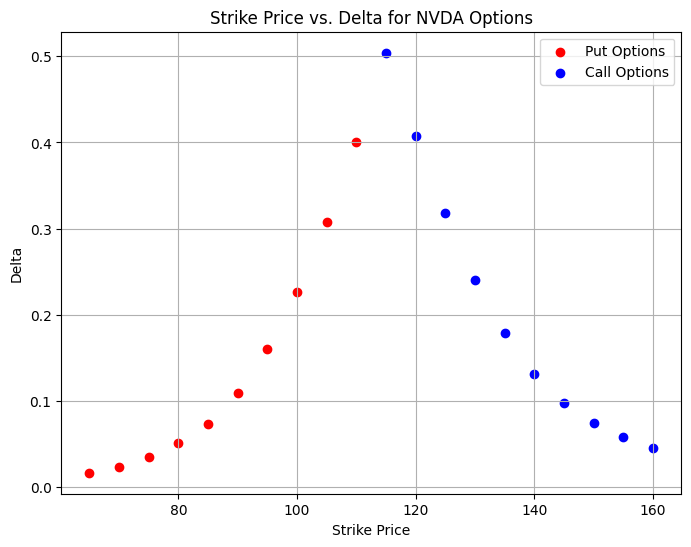

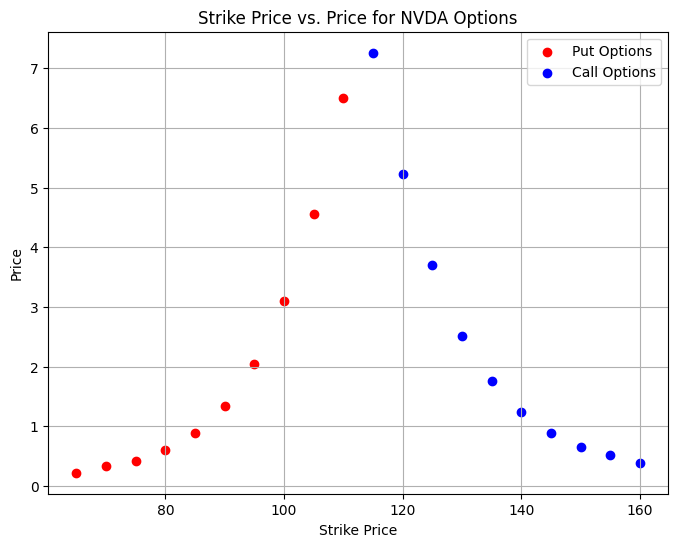

In [ ]:
import matplotlib.pyplot as plt

# Extract data for the first plot (strike vs delta)
strikes_put = [item['strike'] for item in nvda_data_8_3_40dte['put']]
deltas_put = [item['delta'] for item in nvda_data_8_3_40dte['put']]
strikes_call = [item['strike'] for item in nvda_data_8_3_40dte['call']]
deltas_call = [item['delta'] for item in nvda_data_8_3_40dte['call']]

# Create the first scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(strikes_put, deltas_put, color='red', label='Put Options') #Color Put options red
plt.scatter(strikes_call, deltas_call, color='blue', label='Call Options') #Color Call options blue
plt.xlabel('Strike Price')
plt.ylabel('Delta')
plt.title('Strike Price vs. Delta for NVDA Options')
plt.grid(True)
plt.legend()
plt.show()

prices_put = [item['price'] for item in nvda_data_8_3_40dte['put']]
prices_call = [item['price'] for item in nvda_data_8_3_40dte['call']]

# Create the second scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(strikes_put, prices_put, color='red', label='Put Options') #Color Put options red
plt.scatter(strikes_call, prices_call, color='blue', label='Call Options') #Color Call options blue
plt.xlabel('Strike Price')
plt.ylabel('Price')
plt.title('Strike Price vs. Price for NVDA Options')
plt.grid(True)
plt.legend() # Add a legend to differentiate the colors
plt.show()
